<a href="https://colab.research.google.com/github/dujest/yolov5-workshop/blob/main/Deep_CNN_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount your drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install the requirements

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
!mkdir /content/drive/MyDrive/colab

In [3]:
%cd /content/drive/MyDrive/colab

/content/drive/MyDrive/colab


# Download a dataset

In [ ]:
!mkdir "/content/drive/MyDrive/colab/corrosion_dataset"
!wget  "https://universe.roboflow.com/ds/LQgs4TYGAN?key=Q2icURdATO" -O "/content/drive/MyDrive/colab/corrosion_dataset/corrosion.zip"
!unzip "/content/drive/MyDrive/colab/corrosion_dataset/corrosion.zip" -d "/content/drive/MyDrive/colab/corrosion_dataset"
!rm -r "/content/drive/MyDrive/colab/corrosion_dataset/corrosion.zip"

# Load the train and test set

The next preprocessing and augmentations steps were applied:
- Auto-Orient: Applied
- Resize: Stretch to 416x416
- Outputs per training example: 3
- Flip: Horizontal, Vertical
- 90° Rotate: Clockwise, Counter-Clockwise, Upside Down
- Saturation: Between -15% and +15%
- Brightness: Between -12% and +12%
- Exposure: Between -5% and +5%
- Blur: Up to 0.5px

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(320), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/colab/corrosion_dataset/train', transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/colab/corrosion_dataset/valid', transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ("Corrosion", "No corrosion")

# Display function

In [5]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (15, 50)

# displays unnormalized images
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
# fetchs a batch from the train set
dataiter = iter(trainloader)
images, labels = dataiter.next()

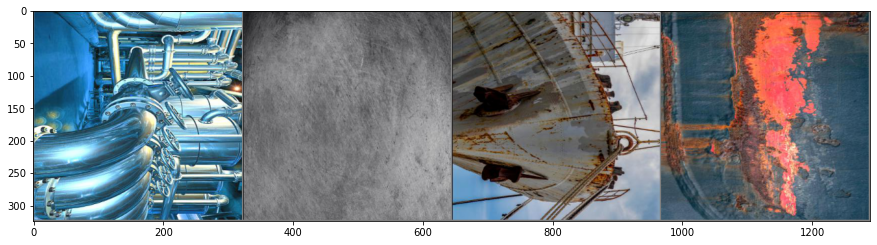

No corrosion
No corrosion
Corrosion 
Corrosion 


In [ ]:
imshow(torchvision.utils.make_grid(images))
print('\n'.join(f'{classes[labels[j]]:10s}' for j in range(batch_size)))

# The CNN model

In [7]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, and so on.

The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps), thanks to the convolutional layers. At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction.

In [8]:
conv1 = nn.Conv2d(3, 16, 5, padding='same').to(device)   # nn.Conv2d(input_channel, output_channel, filter_size)
pool = nn.MaxPool2d(2, 2).to(device)                     # nn.MaxPool2d(filter_size, stride)
conv2 = nn.Conv2d(16, 64, 3, padding='same').to(device)
conv3 = nn.Conv2d(64, 256, 3, padding='same').to(device)
fc1 = nn.Linear(256 * 40 * 40, 120).to(device)           # nn.Linear(input_features, output_features)
fc2 = nn.Linear(120, 84).to(device)                      # fc = fully connected
fc3 = nn.Linear(84, 2).to(device)

print(f'Before Conv1:\n {images[0][0]}')

print(f'\nThe image size:{images.shape}')

images = images.to(device)
print(f'\nThe image is sent to {images.device}')

x = conv1(images)
print(f'\nAfter Conv1 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

x = conv2(x)
print(f'\nAfter Conv2 the image size is: {x.shape}')

x = pool(x)
print(f'\nAfter MaxPool the image size is: {x.shape}')

print(f'\nAfter two convolutions and maxpools the tensor is: \n\n{x[0][0]}')
print(f'\nAfter ReLU the tensor is: \n\n{F.relu(x[0][0])}')

x = torch.flatten(x, 1)
print(f'\nAfter flatten the image size is: {x.shape}')

x = fc1(x)
print(f'\nAfter fc1 the image size is: {x.shape}')

x = fc2(x)
print(f'\nAfter fc2 the image size is: {x.shape}')

x = fc3(x)
print(f'\nAfter fc3 the image size is: {x.shape}')

Before Conv1:
 tensor([[-0.1836, -0.1051, -0.0556,  ..., -0.2513, -0.3201, -0.3135],
        [-0.2959, -0.4351, -0.3493,  ..., -0.4390, -0.3509, -0.3656],
        [ 0.2492,  0.1577,  0.1863,  ..., -0.0613, -0.1248, -0.1891],
        ...,
        [ 0.2627,  0.2627,  0.2627,  ...,  0.0319,  0.0275,  0.0258],
        [ 0.2627,  0.2627,  0.2627,  ...,  0.0275,  0.0251,  0.0201],
        [ 0.2627,  0.2627,  0.2627,  ...,  0.0258,  0.0201,  0.0196]])

The image size:torch.Size([4, 3, 320, 320])

The image is sent to cuda:0

After Conv1 the image size is: torch.Size([4, 16, 320, 320])

After MaxPool the image size is: torch.Size([4, 16, 160, 160])

After Conv2 the image size is: torch.Size([4, 64, 160, 160])

After MaxPool the image size is: torch.Size([4, 64, 80, 80])

After two convolutions and maxpools the tensor is: 

tensor([[ 0.1419,  0.1255,  0.1104,  ...,  0.1627,  0.1688,  0.1170],
        [ 0.1494,  0.1922,  0.0783,  ...,  0.1627,  0.2151,  0.1081],
        [ 0.0115,  0.0381,  0.050

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 64, 3, padding='same')
        self.conv3 = nn.Conv2d(64, 256, 3, padding='same')
        self.fc1 = nn.Linear(256 * 40 * 40, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net().to(device)

# Optimizer and loss function

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

# Train the CNN model

In [11]:
%%time

epochs = 10

for epoch in range(epochs):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)
          
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49 :    # print every xy mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 0.067
[1,   100] loss: 0.058
[1,   150] loss: 0.058
[2,    50] loss: 0.058
[2,   100] loss: 0.052
[2,   150] loss: 0.047
[3,    50] loss: 0.050
[3,   100] loss: 0.050
[3,   150] loss: 0.043
[4,    50] loss: 0.039
[4,   100] loss: 0.039
[4,   150] loss: 0.038
[5,    50] loss: 0.036
[5,   100] loss: 0.036
[5,   150] loss: 0.034
[6,    50] loss: 0.034
[6,   100] loss: 0.027
[6,   150] loss: 0.033
[7,    50] loss: 0.030
[7,   100] loss: 0.016
[7,   150] loss: 0.037
[8,    50] loss: 0.025
[8,   100] loss: 0.029
[8,   150] loss: 0.014
[9,    50] loss: 0.018
[9,   100] loss: 0.014
[9,   150] loss: 0.016
[10,    50] loss: 0.022
[10,   100] loss: 0.010
[10,   150] loss: 0.009
Finished Training
CPU times: user 35.6 s, sys: 3.09 s, total: 38.7 s
Wall time: 1min 39s


# Predictions

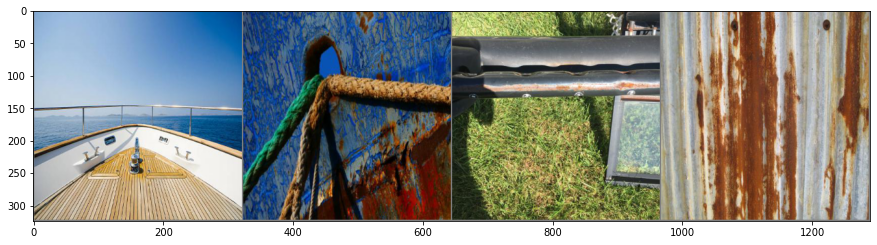

GroundTruth:
No corrosion
Corrosion
Corrosion
Corrosion


In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth:')
print('\n'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [17]:
images = images.to(device)
outputs = model(images)

In [18]:
_, predicted = torch.max(outputs, 1)

print('Predicted:')
print('\n'.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:
Corrosion
Corrosion
Corrosion
Corrosion


# Accuracy

In [20]:
correct = 0
total = 0

y_pred = []
y_true = []

with torch.no_grad():
    for data in testloader:
        images, labels = data

        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        y_true.extend(labels.data.cpu().numpy()) # Save Truth

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testloader)*batch_size} test images: {100 * correct // total} %')

Accuracy of the network on the 60 test images: 76 %


# Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

df_cm

,Corrosion,No corrosion
Corrosion,36,9
No corrosion,5,10
